In [76]:
import numpy as np
# Visualization
import matplotlib
import matplotlib.pyplot as plt # for plotting model loss
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version
import plotly
import plotly.express as px # for data visualization
print('plotly: %s' % plotly.__version__) # print version


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense,  Lambda, Flatten, Reshape
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model


#from tensorflow.keras import layers

matplotlib: 3.7.1
graphviz: 0.20.1
plotly: 5.13.1


## Loading Dataset

In [77]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
input_shape = x_train.shape[1:]

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [78]:
## Normalize input data
x_train, x_test = x_train / 255.0, x_test / 255.0

# flatten the label values
y_train, y_test = y_train.flatten(), y_test.flatten()

In [79]:
# print shape
print("Shape of X_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (50000, 32, 32, 3)
Shape of y_train:  (50000,)
Shape of X_test:  (10000, 32, 32, 3)
Shape of y_test:  (10000,)


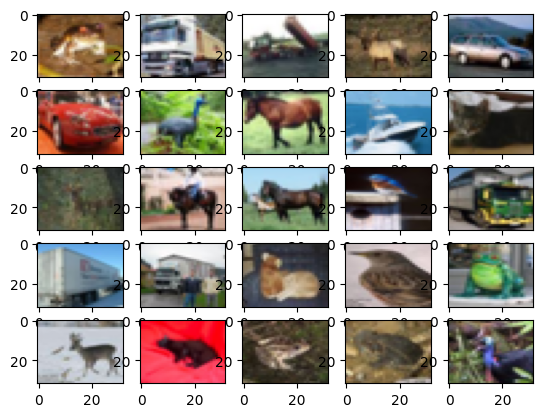

In [80]:
# visualize data by plotting images
fig, ax = plt.subplots(5, 5)
k = 0

for i in range(5):
    for j in range(5):
        ax[i][j].imshow(x_train[k], aspect='auto')
        k += 1

plt.show()

## Preprocessing

In [81]:
# Convert labels to one-hot encoding
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

## Building model

In [82]:
# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                             mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [83]:
# Define VAE architecture
latent_dim = 64

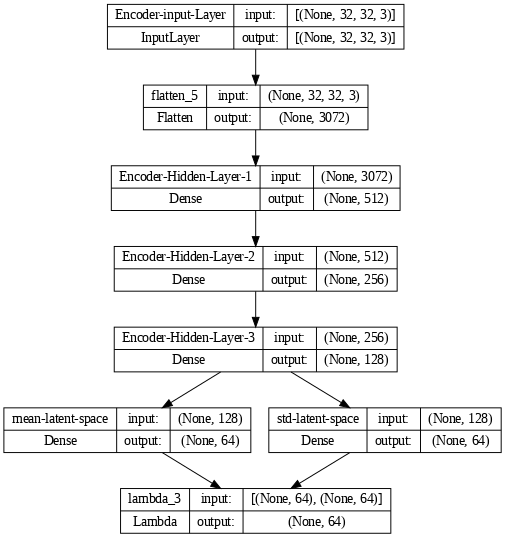

In [84]:
# Encoder
#--- Input Layer
encoder_input = Input(shape=input_shape,name='Encoder-input-Layer')     # input

#--- Flatten
x = Flatten()(encoder_input,)

#--Layers
x = Dense(512, activation='relu',name='Encoder-Hidden-Layer-1')(x)         # first layer
x = Dense(256, activation='relu',name='Encoder-Hidden-Layer-2')(x)         # second layer
x = Dense(128, activation='relu',name='Encoder-Hidden-Layer-3')(x)         # third layer (input for latent space)

#--- Custom Latent Space Layer
z_mean = Dense(latent_dim ,name='mean-latent-space')(x)                # Z mean for latent space
z_log_var = Dense(latent_dim ,name='std-latent-space')(x)             # Z std for latent space
z = Lambda(sampling)([z_mean, z_log_var])
#--- Create Encoder model
encoder = Model(encoder_input, [z_mean, z_log_var, z], name='encoder-network')          # encoder network

# Display model diagram
plot_model(encoder, show_shapes=True, dpi=70)                                         # Plot layers Diagram
# Display model summary
#encoder.summary()

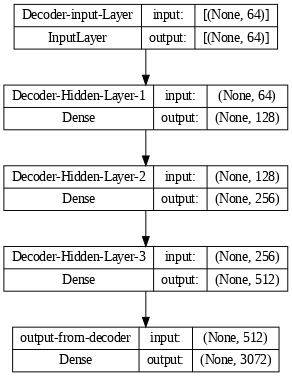

In [85]:
# Decoder
#--- Input Layer
decoder_input = Input(shape=(latent_dim,),name='Decoder-input-Layer')                                 # input (from latent space)

#--- Layers
x = Dense(128, activation='relu',name='Decoder-Hidden-Layer-1')(decoder_input)                           # first layer
x = Dense(256, activation='relu',name='Decoder-Hidden-Layer-2')(x)                                       # second layer
x = Dense(512, activation='relu',name='Decoder-Hidden-Layer-3')(x)                                       # third layer
decoder_output = Dense(np.prod(input_shape), activation='relu',name='output-from-decoder')(x)
#decoder_output = tf.reshape(x, shape=(K.shape(x)[0], *input_shape))                                      # output

#--- Create Encoder model
decoder = Model(decoder_input, decoder_output, name='decoder-network')                  # decoser network

# Display model diagram
plot_model(decoder, show_shapes=True, dpi=70)                                         # Plot layers Diagram
# Display model summary
#encoder.summary()

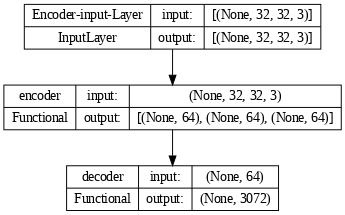

In [86]:
# VAE model - Define
encoder = Model(encoder_input, [z_mean, z_log_var, z], name='encoder')          # encoder network
decoder = Model(decoder_input, decoder_output, name='decoder')                  # decoser network
vae = Model(encoder_input, decoder(encoder(encoder_input)[2]), name='vae')      # vae model (input&output)

# Display Vae model diagram
plot_model(vae, show_shapes=True, dpi=70)

**Define Loss functions**

In [87]:
# Define the reconstruction loss
reconstruction_loss = mse(K.flatten(encoder_input), K.flatten(vae.outputs[0]))
reconstruction_loss *= 32 * 32 * 3
#Define the KL divergence loss
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
# Define the total loss
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

**Training model**

In [88]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
#optimizer.minimize(vae_loss,var_list=[var1])
#vae.compile( optimizer='adam',metrics=['acc'])
#vae.compile(optimizer='adam')
vae.compile(optimizer=optimizer)

In [89]:
# Train the VAE
history = vae.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/50
391/391 [==============================] - 47s 115ms/step - loss: 163.7279 - val_loss: 129.7180
Epoch 2/50
391/391 [==============================] - 46s 116ms/step - loss: 122.9199 - val_loss: 115.2220
Epoch 3/50
391/391 [==============================] - 44s 114ms/step - loss: 108.3385 - val_loss: 103.2291
Epoch 4/50
391/391 [==============================] - 46s 117ms/step - loss: 99.9436 - val_loss: 97.2769
Epoch 5/50
391/391 [==============================] - 44s 113ms/step - loss: 95.3973 - val_loss: 94.1222
Epoch 6/50
391/391 [==============================] - 46s 117ms/step - loss: 92.8252 - val_loss: 92.3783
Epoch 7/50
391/391 [==============================] - 45s 114ms/step - loss: 91.3386 - val_loss: 91.0731
Epoch 8/50
391/391 [==============================] - 46s 117ms/step - loss: 90.2136 - val_loss: 90.0987
Epoch 9/50
391/391 [==============================] - 44s 113ms/step - loss: 89.2533 - val_loss: 89.4016
Epoch 10/50
391/391 [============================

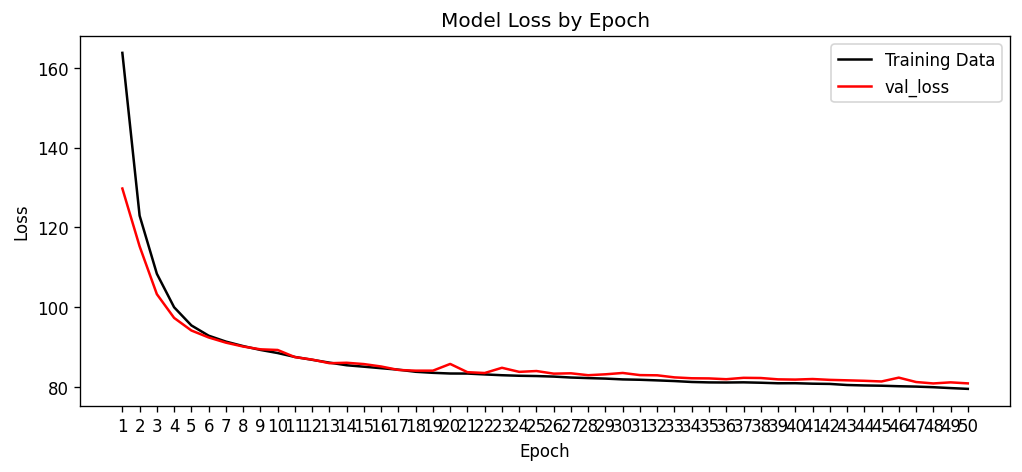

In [90]:
# Plot a loss chart
fig, ax = plt.subplots(figsize=(10,4), dpi=120)
plt.title(label='Model Loss by Epoch', loc='center')
ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='val_loss', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()

313/313 [==============================] - 3s 8ms/step


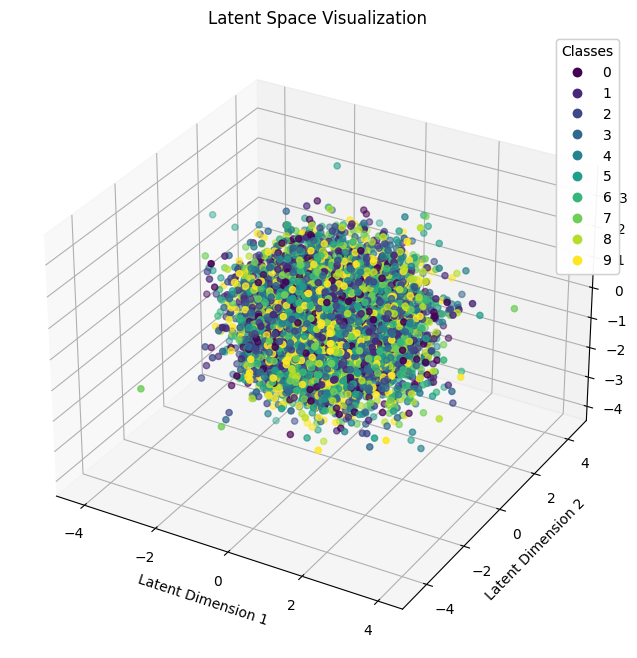

In [91]:
# Plot the latent space
latent_points = encoder.predict(x_test)[2]
labels = np.argmax(y_test, axis=1)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(latent_points[:, 0], latent_points[:, 1], latent_points[:, 2], c=labels, cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.title('Latent Space Visualization')
plt.show()

In [ ]:
 #Encode inputs into the latent space
##encoded_images = encoder.predict(x_test)

# Plot the latent space distribution
##plt.figure(figsize=(20, 8))
##plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=np.argmax(y_test, axis=1), cmap='tab10')
##plt.colorbar()
##plt.xlabel('Latent Dimension 1')
##plt.ylabel('Latent Dimension 2')
##plt.title('Latent Space Distribution')
##plt.show()

## Data augmentation

In [92]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
# Define ImageDataGenerator for synthetic data generation
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Generate synthetic data
num_synthetic = 20000
synthetic_images = []
synthetic_labels = []
for _ in range(num_synthetic):
  synthetic_image = datagen.flow(np.zeros((1, 32, 32, 3)), batch_size=1, shuffle=False).next()
  synthetic_images.append(synthetic_image[0])
  synthetic_labels.append(np.random.randint(0, num_classes))

synthetic_images = np.array(synthetic_images)
synthetic_labels = to_categorical(synthetic_labels, num_classes)

# Concatenate synthetic data with the original training set
x_train = np.concatenate((x_train, synthetic_images), axis=0)
y_train = np.concatenate((y_train, synthetic_labels), axis=0)

In [94]:
# Train the VAE
history = vae.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/10
547/547 [==============================] - 64s 117ms/step - loss: 58.8511 - val_loss: 81.2006
Epoch 2/10
547/547 [==============================] - 64s 118ms/step - loss: 58.1514 - val_loss: 81.1253
Epoch 3/10
547/547 [==============================] - 61s 111ms/step - loss: 57.9929 - val_loss: 81.6924
Epoch 4/10
547/547 [==============================] - 62s 113ms/step - loss: 57.9186 - val_loss: 81.2192
Epoch 5/10
547/547 [==============================] - 62s 113ms/step - loss: 57.8993 - val_loss: 81.1502
Epoch 6/10
547/547 [==============================] - 62s 113ms/step - loss: 57.9084 - val_loss: 82.6731
Epoch 7/10
547/547 [==============================] - 61s 112ms/step - loss: 57.7949 - val_loss: 81.3761
Epoch 8/10
547/547 [==============================] - 62s 113ms/step - loss: 57.8040 - val_loss: 81.0699
Epoch 9/10
547/547 [==============================] - 62s 113ms/step - loss: 57.8115 - val_loss: 81.7230
Epoch 10/10
547/547 [==============================] - 

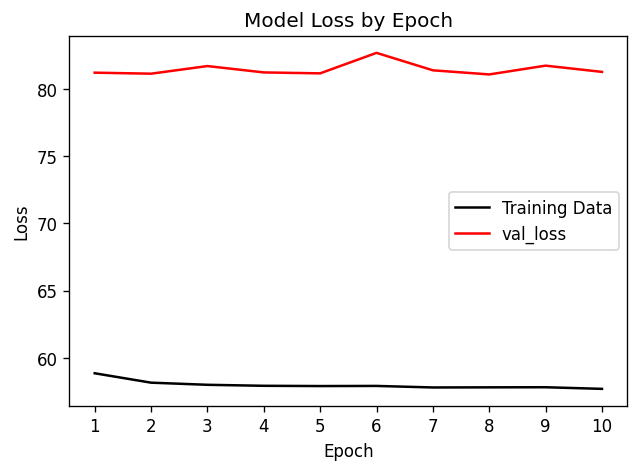

In [95]:
# Plot a loss chart
fig, ax = plt.subplots(figsize=(6,4), dpi=120)
plt.title(label='Model Loss by Epoch', loc='center')
ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='val_loss', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()

313/313 [==============================] - 2s 6ms/step


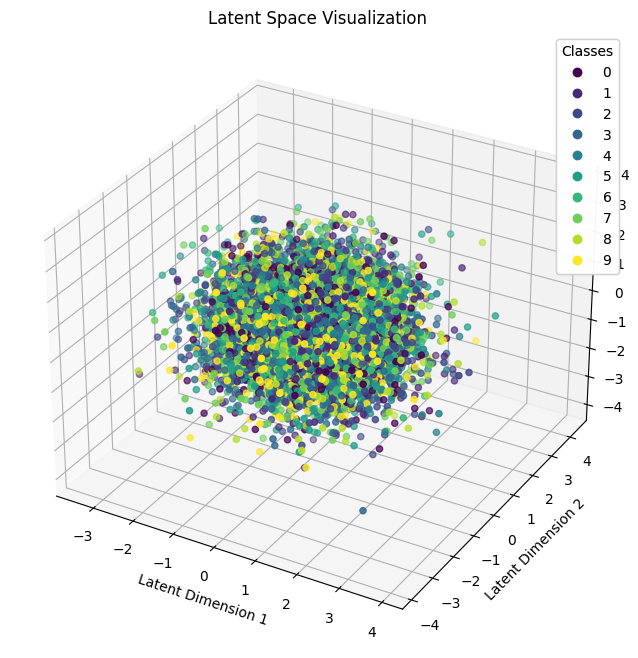

In [96]:
# Plot the latent space 3D
latent_points = encoder.predict(x_test)[2]
labels = np.argmax(y_test, axis=1)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(latent_points[:, 0], latent_points[:, 1], latent_points[:, 2], c=labels, cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.title('Latent Space Visualization')
plt.show()

In [97]:
 #Encode inputs into the latent space
#encoded_images = encoder.predict(x_test)

# Plot the latent space distribution 2D
#plt.figure(figsize=(20, 8))
#plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=np.argmax(y_test, axis=1), cmap='tab10')
#plt.colorbar()
#plt.xlabel('Latent Dimension 1')
#plt.ylabel('Latent Dimension 2')
#plt.title('Latent Space Distribution')
#plt.show()

## Classification Model

In [98]:
# Use the trained encoder for classification
encoder = Model(encoder_input, z)
encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)

313/313 [==============================] - 2s 5ms/step


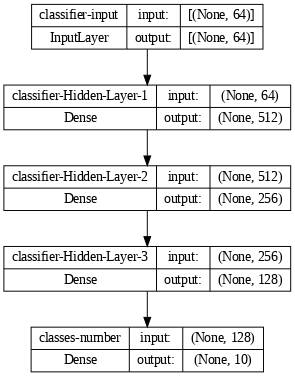

In [99]:
# Classification model
classifier_input = Input(shape=(latent_dim,),name='classifier-input')
x = Dense(512, activation='relu',name='classifier-Hidden-Layer-1')(classifier_input)
x = Dense(256, activation='relu',name='classifier-Hidden-Layer-2')(x)
x = Dense(128, activation='relu',name='classifier-Hidden-Layer-3')(x)
classifier_output = Dense(num_classes, activation='relu',name='classes-number')(x)

#--- Create Encoder model
classifier = Model(classifier_input, classifier_output)

# Display model diagram
plot_model(classifier, show_shapes=True, dpi=70)

In [100]:
# Compile and train the classifier
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = classifier.fit(encoded_train, y_train, epochs=10, batch_size=32, validation_data=(encoded_test, y_test))

Epoch 1/10
2188/2188 [==============================] - 15s 7ms/step - loss: 3.5036 - accuracy: 0.1764 - val_loss: 3.4686 - val_accuracy: 0.1616
Epoch 2/10
2188/2188 [==============================] - 15s 7ms/step - loss: 3.4391 - accuracy: 0.2009 - val_loss: 3.4734 - val_accuracy: 0.1757
Epoch 3/10
2188/2188 [==============================] - 14s 7ms/step - loss: 3.3847 - accuracy: 0.2234 - val_loss: 3.3584 - val_accuracy: 0.2453
Epoch 4/10
2188/2188 [==============================] - 14s 6ms/step - loss: 3.3525 - accuracy: 0.2406 - val_loss: 3.2873 - val_accuracy: 0.2877
Epoch 5/10
2188/2188 [==============================] - 14s 6ms/step - loss: 3.3278 - accuracy: 0.2498 - val_loss: 3.2127 - val_accuracy: 0.3189
Epoch 6/10
2188/2188 [==============================] - 14s 6ms/step - loss: 3.2909 - accuracy: 0.2670 - val_loss: 3.2147 - val_accuracy: 0.3282
Epoch 7/10
2188/2188 [==============================] - 14s 6ms/step - loss: 3.2715 - accuracy: 0.2758 - val_loss: 3.1887 - val_ac

In [101]:
# Train vs Test visualization
train_predictions = np.argmax(classifier.predict(encoded_train), axis=1)
test_predictions = np.argmax(classifier.predict(encoded_test), axis=1)

313/313 [==============================] - 1s 2ms/step


## Results and conclusions

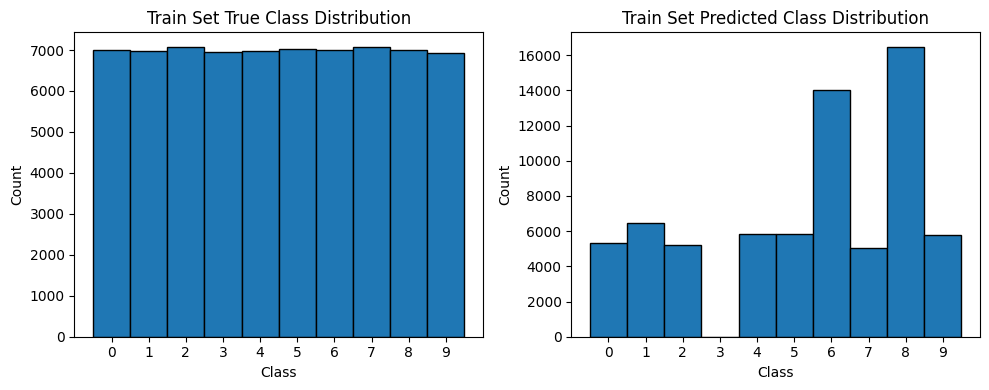

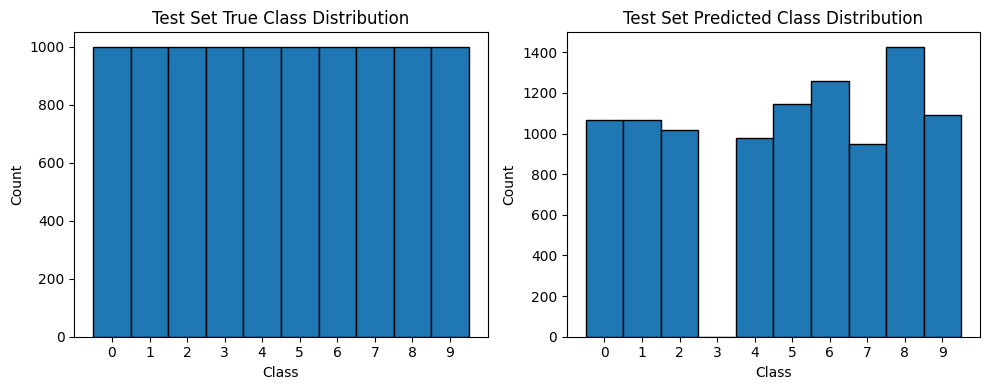

In [102]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(np.argmax(y_train, axis=1), bins=np.arange(num_classes + 1) - 0.5, edgecolor='black')
plt.title('Train Set True Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(np.arange(num_classes))
plt.subplot(1, 2, 2)
plt.hist(train_predictions, bins=np.arange(num_classes + 1) - 0.5, edgecolor='black')
plt.title('Train Set Predicted Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(np.arange(num_classes))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(np.argmax(y_test, axis=1), bins=np.arange(num_classes + 1) - 0.5, edgecolor='black')
plt.title('Test Set True Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(np.arange(num_classes))
plt.subplot(1, 2, 2)
plt.hist(test_predictions, bins=np.arange(num_classes + 1) - 0.5, edgecolor='black')
plt.title('Test Set Predicted Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(np.arange(num_classes))
plt.tight_layout()
plt.show()


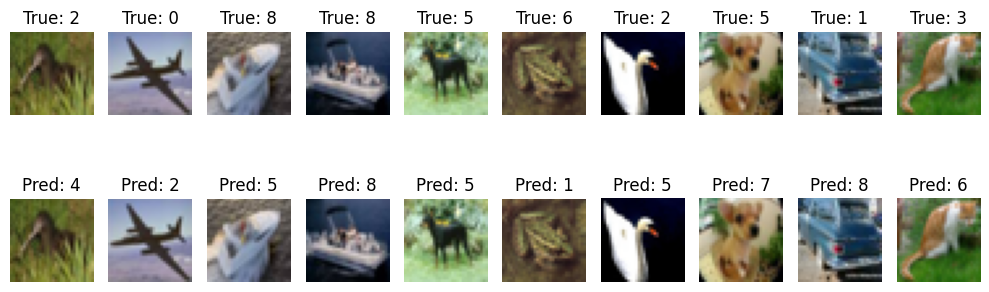

In [103]:
# True image classification vs predicted image classification
num_samples = 10
selected_indices = np.random.choice(len(x_test), num_samples, replace=False)

plt.figure(figsize=(10, 4))
for i, index in enumerate(selected_indices):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_test[index])
    plt.title('True: {}'.format(np.argmax(y_test[index])))
    plt.axis('off')
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(x_test[index])
    plt.title('Pred: {}'.format(test_predictions[index]))
    plt.axis('off')
plt.tight_layout()
plt.show()

313/313 [==============================] - 1s 2ms/step


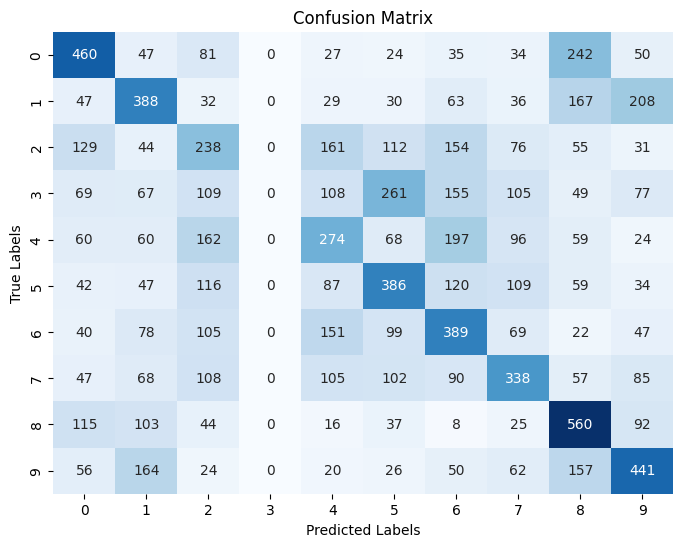

In [104]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Confusion matrix
test_predictions = np.argmax(classifier.predict(encoded_test), axis=1)
test_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

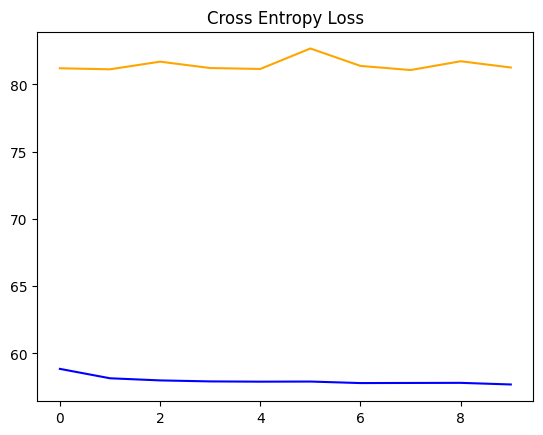

In [105]:
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')

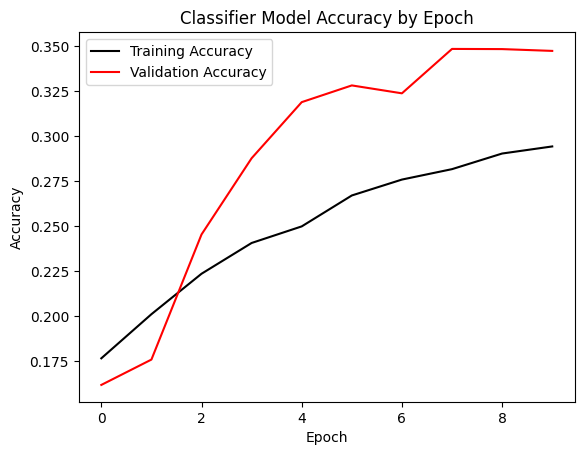

In [107]:
# Plot the accuracy chart
accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']

plt.plot(accuracy, label='Training Accuracy', color='black')
plt.plot(val_accuracy, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classifier Model Accuracy by Epoch')
plt.legend()
plt.show()

In [108]:
# Evaluate the classifier on test data
test_loss, test_accuracy = classifier.evaluate(encoded_test, y_test, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Test Loss: 3.1686809062957764
Test Accuracy: 0.3474000096321106


In [109]:
# Predict classes for test data
y_pred = classifier.predict(encoded_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

313/313 [==============================] - 1s 3ms/step


In [112]:
# Calculate the number of correctly predicted samples
correctly_predicted = np.sum(y_pred == y_true)
total_samples = len(y_true)

print('Correctly Predicted:', correctly_predicted)
print('Total Samples:', total_samples)
print('Accuracy:', correctly_predicted / total_samples)

Correctly Predicted: 3474
Total Samples: 10000
Accuracy: 0.3474
